In [8]:
import numpy as np
import sys
sys.path.append("../..")
import lib.haar_wawelet_method.gradients as grad
import lib.data as data
import matplotlib.pyplot as plt
import lib.mesurements
import lib.haar_wawelet_method.haar as haar
%matplotlib inline
def get_g1(u, N1, N2):
    h1, h2 = 2 * np.pi / N1, 2 * np.pi / N2
    x, y = np.linspace(-np.pi, np.pi, N1), np.linspace(-np.pi, np.pi, N2)
    g1 = np.zeros((len(x),len(y)))
    for n in range(1, N1):
        for m in range(1, N2):
            g1[n,m] = (u(x[n], (y[m] + y[m - 1]) / 2) - u(x[n-1], (y[m] + y[m - 1]) / 2)) / h1
    for n in range(N1):
        g1[n,0] = g1[n,1]
    for m in range(N2):
        g1[0,m] = g1[1,m]    
    return g1

def get_g2(u, N1, N2):
    h1, h2 = 2 * np.pi / N1, 2 * np.pi / N2
    x, y = np.linspace(-np.pi, np.pi, N1), np.linspace(-np.pi, np.pi, N2)
    g2 = np.zeros((len(x),len(y)))
    for n in range(1, N1):
        for m in range(1, N2):
            g2[n,m] = (u((x[n] + x[n-1]) / 2, y[m]) - u((x[n] + x[n-1]) / 2, y[m - 1])) / h2
    for n in range(N1):
        g2[n,0] = g2[n,1]
    for m in range(N2):
        g2[0,m] = g2[1,m]    
    return g2

In [2]:
def my_exp(x,y,w1,w2):
    if (w1 == 0):
        return np.exp( w2*1j*y)
    return np.exp(w1*1j*x + w2*1j*y)

In [11]:
def draw_plot(z):
    size = z.shape[0]
    x,y = np.meshgrid(range(0,size),range(0,size))
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(30,30))
    ax = fig.gca(projection='3d')
    ax.plot_wireframe(x, y, z)
    ax.set_zlim(0, 2)
    ax.set_xlim(0,size)
    ax.set_ylim(0,size)
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    majorLocator = MultipleLocator(1)
    majorFormatter = FormatStrFormatter('%d')
    ax.xaxis.set_major_locator(majorLocator)
    ax.xaxis.set_major_formatter(majorFormatter)
    ax.yaxis.set_major_locator(majorLocator)
    ax.yaxis.set_major_formatter(majorFormatter)
    #plt.savefig('z-plot-ideal')

In [26]:
def compare_ideal(i,j,M, noised = False, photons = 1):
    x,y = data.get_plane(-np.pi, np.pi, -np.pi, np.pi, M)
    im = my_exp(x,y,i,j)
    h = 2*np.pi / 2**M
    #grad_X, grad_Y = i * 1j * my_exp(x,y,i,j) * h, j * 1j * my_exp(x,y,i,j) * h
    grad_X, grad_Y = get_g2(lambda x,y:np.exp(i*1j*x + j*1j*y), 2**M, 2**M)*h, get_g1(lambda x,y:np.exp(i*1j*x + j*1j*y),2**M, 2**M) * h
    if (noised):
        #как зашумлять комплексные числа?
        grad_X = data.get_Poisson_noise(grad_X.real, photons) + 1j*data.get_Poisson_noise(grad_X.imag, photons)
        grad_Y = data.get_Poisson_noise(grad_Y.real, photons) + 1j*data.get_Poisson_noise(grad_Y.imag, photons)
    LH, HL, HH = haar.analyze(grad_X, grad_Y, grad_X, grad_Y)
    res = haar.syntesis({0:np.array([[np.mean(im)*2**M]])}, LH, HL, HH,M)
    return np.abs(np.fft.fft2(im)[j,i])/np.abs(np.fft.fft2(res[M])[j,i])

In [27]:
def calc_z_ideal (M, noised = False, photons = 1):
    size = 2**M
    z = np.zeros(size**2).reshape(size,size)
    for i in range (size):
        print(i)
        if (i*10 <= size):
            for j in range(size):
                if (j*10 <= size):
                    z[i,j] = compare_ideal(i,j,M, noised,photons)
                else:
                    break
        else :
            break
    return z

0


/home/satbek/python/anacondas/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
/home/satbek/python/anacondas/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()
../../lib/data.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scale_factor = photons / noised_image.max()
../../lib/data.py:45: RuntimeWarning: invalid value encountered in multiply
  noised_image = noised_image * scale_factor
../../lib/data.py:46: RuntimeWarning: invalid value encountered in less
  noised_image = np.random.poisson(noised_image)
../../lib/data.py:46: RuntimeWarning: invalid value encountered in greater
  noised_image = np.random.poisson(noised_image)


1
2
3
4
5
6
7
8
9
10
11
12
13


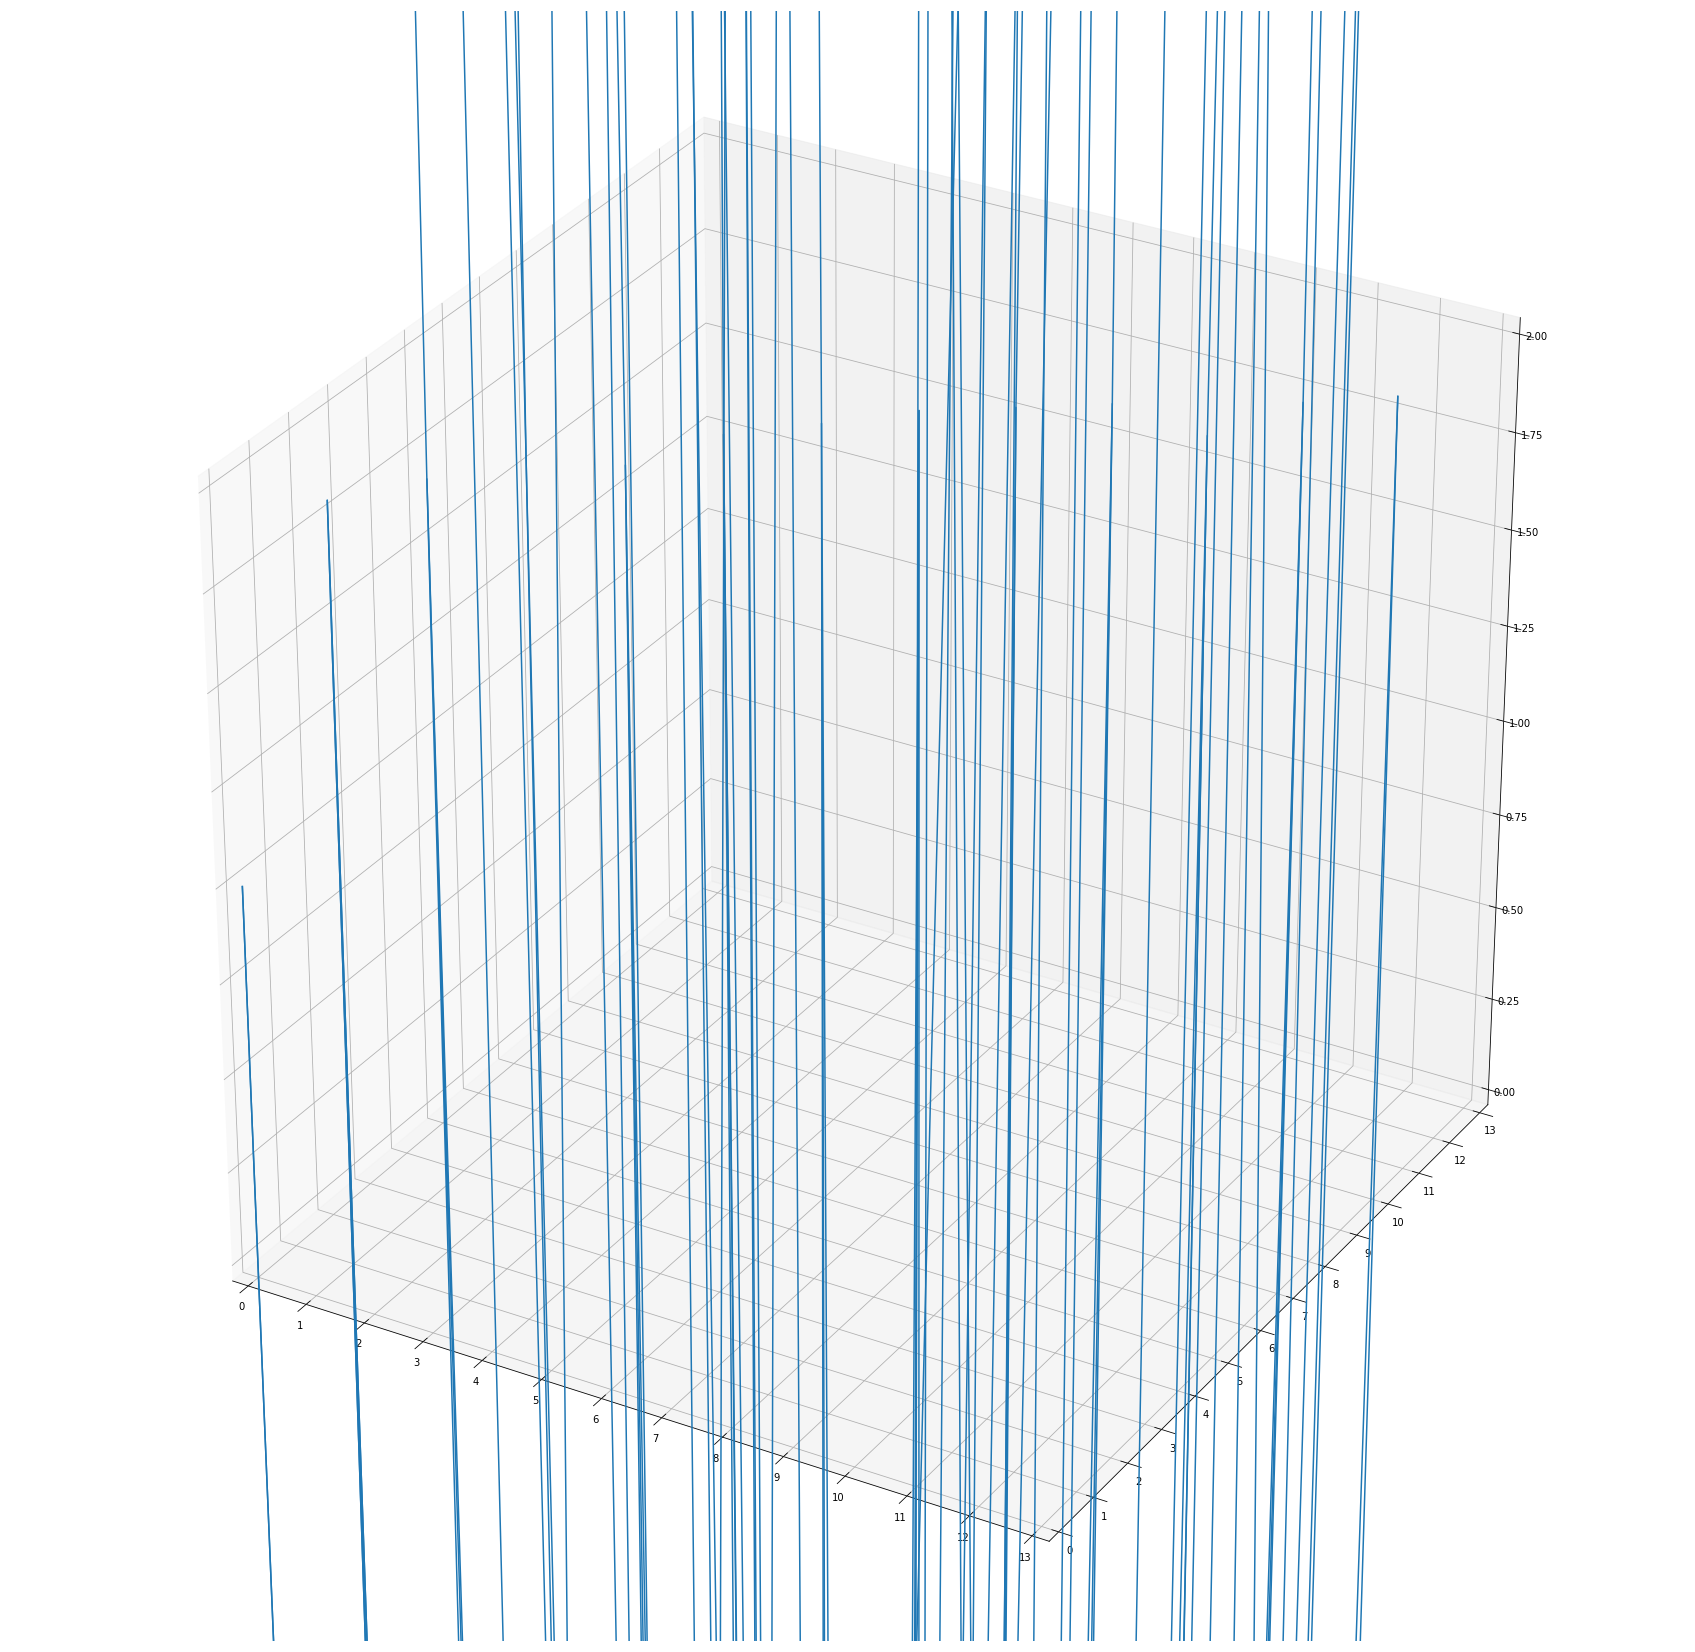

In [28]:
z = calc_z_ideal(7, True, 1)
draw_plot(z[0:z.shape[0] // 10 + 1, 0:z.shape[0] // 10 + 1])

In [12]:
plt.savefig('/home/satbek/Course-work-sem7/tex/pictures/haar/frequency/ideal.png')

<Figure size 432x288 with 0 Axes>

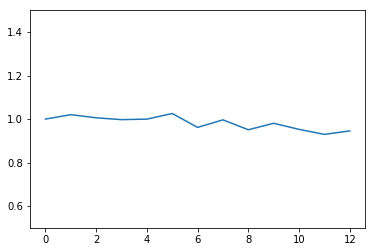

In [12]:
x = np.arange(z.shape[0] // 10 + 1)
y = [z[i,i] for i in range(z.shape[0] // 10 + 1)]
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)
plt.ylim(0.5,1.5)
plt.plot(x,y)

In [ ]:
fig.savefig()